# Final Project: Sentiment Analysis on Covid-19 Tweets  
**Math189Z – Covid-19: Data Analytics and Machine Learning**  
Nico Espinosa Dice  
*May, 2020*  

## Sources
This project uses theory presented in the following academic papers:  
- [Sentiment Analysis of Twitter Data](http://www.cs.columbia.edu/~julia/papers/Agarwaletal11.pdf) (1)

- [Sentiment Analysis of Twitter Data](https://arxiv.org/pdf/1711.10377.pdf) (2)

- [Covid-19 Tweets Dataset and Statistics](https://ieee-dataport.org/open-access/corona-virus-covid-19-tweets-dataset)


This project uses code that was inspired and adapted from the following open-source resources:  
- [Twitter Sentiment Analysis with Explanation (Naive Bayes)](https://medium.com/@koshut.takatsuji/twitter-sentiment-analysis-with-full-code-and-explanation-naive-bayes-a380b38f036b)

- [Creating The Twitter Sentiment Analysis Program in Python with Naive Bayes Classification](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)

- [How to Do Sentiment Analysis on a Twitter Account](https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082)

- [Comprehensive Hands on Guide to Twitter Sentiment Analysis with dataset and code](https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/)

### Data
The dataset of Tweets was provided by Professor Gu as part of HMC Math189Z. The data is available [here](https://math189covid19.github.io/resources.html). The original source of the data is unknown at this time.

The Twitter sentiment corpus was provided in this [public repository](https://github.com/zfz/twitter_corpus).

The Covid-19 related data was provided in this [public repository](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases/resource/d037a9e3-69d8-4452-bc51-3e225fca75c3).

## Importing Data

In [1]:
# Imports the necessary libraries
import numpy as np
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# Imports data into Pandas dataframe
feb_tweets = pd.read_csv('feb_data.csv')
march_tweets = pd.read_csv('march_data.csv')
april_tweets = pd.read_csv('april_data.csv')

In [3]:
# Sets column names of dataframes and drop unnecessary column
feb_tweets.columns, march_tweets.columns, april_tweets.columns = ['Number', "Date", "Text"], ['Number', "Date", "Text"], ['Number', "Date", "Text"]
feb_tweets = feb_tweets.drop(columns = ["Number"])
march_tweets = march_tweets.drop(columns = ["Number"])
april_tweets = april_tweets.drop(columns = ["Number"])

In [4]:
feb_tweets["Month"] = "February"
march_tweets["Month"] = "March"
april_tweets["Month"] = "April"

data = pd.concat([feb_tweets, march_tweets, april_tweets], ignore_index=True)

## Exploratory Data Analysis

In [5]:
feb_tweets.head()

,Date,Text,Month
0,2020-02-19 23:59:11,Head nurse Cai Liping of Wuchang Hospital died...,February
1,2020-02-19 23:59:00,This bacteria-killing UV light robot helps a W...,February
2,2020-02-19 23:56:52,For those that are into the business side of s...,February
3,2020-02-19 23:55:34,How to fight against #coronavirus in #japan,February
4,2020-02-19 23:53:03,Diseases like covid-19 are deadlier in non-dem...,February


In [6]:
data.head()

,Date,Text,Month
0,2020-02-19 23:59:11,Head nurse Cai Liping of Wuchang Hospital died...,February
1,2020-02-19 23:59:00,This bacteria-killing UV light robot helps a W...,February
2,2020-02-19 23:56:52,For those that are into the business side of s...,February
3,2020-02-19 23:55:34,How to fight against #coronavirus in #japan,February
4,2020-02-19 23:53:03,Diseases like covid-19 are deadlier in non-dem...,February


## Data Preprocessing

### Data Cleaning

In [7]:
new_stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

In [8]:
# "cleans" the text by removing hyperlinks, hashtags, mentions, and retweets
# This function was suggested here: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082
def cleanText(text):
    text = text.lower() # Makes text lowercase
    text = re.sub('https?:\/\/\S+', '', text) # Removes hyperlinks
    text = re.sub('#', '', text) # Removes hashtags
    text = re.sub('@[A-Za-z0–9]+', '', text) # Removes mentions (@)
    text = re.sub('RT[\s]+', '', text) # Removes "RT"
    return text

In [12]:
def convertToList(text):
    text = word_tokenize(text)
    return [word for word in text if word not in new_stopwords] # Source for this line: https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed

In [13]:
# Applys cleanText() to every Tweet in dataframe
data["Text"] = data["Text"].apply(cleanText)
data["List of Words"] = data["Text"].apply(convertToList)

In [14]:
def cleanDate(date):
    month = date[5:7]
    day = date[8:10]
    
    if month[0] == "0":
        month = month[1]
    if day[0] == "0":
        day = day[1]
    
    return month + "/" + day + "/20"

In [15]:
data["Date"] = data["Date"].apply(cleanDate)

In [16]:
data.tail()

,Date,Text,Month,List of Words
7495,4/4/20,"breaking: new york ""accidentally"" delivered co...",April,"[breaking, new, york, ``, accidentally, '', de..."
7496,4/4/20,with fewer people around because of coronaviru...,April,"[fewer, people, around, coronavirus, endangere..."
7497,4/4/20,if joe biden is talking about the trump admini...,April,"[joe, biden, talking, trump, administration, ’..."
7498,4/4/20,"in case you know anyone looking for a job, par...",April,"[case, know, anyone, looking, job, partners, h..."
7499,4/4/20,atleast now we all know where lisbon got its c...,April,"[atleast, know, lisbon, got, corona, virus, mo..."


## Feature Engineering

### Polarity
-1 → extreme negative,  
0 → neutral,  
1 → extreme positive.

In [17]:
# Returns the polarity of the Tweet's text
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

In [18]:
# Creates a new column containing the subjectivity of every Tweet
data['Polarity'] = data['Text'].apply(getPolarity)

### Subjectivity
0 → fact,  
1 → opinion.

In [19]:
# Returns the subjectivity of the Tweet's text
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

In [20]:
# Creates a new column containing the subjectivity of every Tweet
data["Subjectivity"] = data["Text"].apply(getSubjectivity)

## Sentiment Analysis
Polarity < 0 → negative,  
Polarity == 0 → neutral,  
Polarity > 0 → positive. 

In [21]:
# Returns the analysis of each Tweet's text
def getSentiment(polarity):
    if polarity < 0:
      return 'Negative'
    elif polarity == 0:
      return 'Neutral'
    else:
      return 'Positive'

In [22]:
data['Analysis'] = data['Polarity'].apply(getSentiment)

In [23]:
data.head()

,Date,Text,Month,List of Words,Polarity,Subjectivity,Analysis
0,2/19/20,head nurse cai liping of wuchang hospital died...,February,"[head, nurse, cai, liping, wuchang, hospital, ...",0.000000,0.095833,Neutral
1,2/19/20,this bacteria-killing uv light robot helps a w...,February,"[bacteria-killing, uv, light, robot, helps, wu...",0.400000,0.700000,Positive
2,2/19/20,for those that are into the business side of s...,February,"[business, side, sneakers, adidas, business, r...",-0.126852,0.354630,Negative
3,2/19/20,how to fight against coronavirus in japan,February,"[fight, coronavirus, japan]",0.000000,0.000000,Neutral
4,2/19/20,diseases like covid-19 are deadlier in non-dem...,February,"[diseases, like, covid-19, deadlier, non-democ...",0.627500,0.832500,Positive


## Analysis

### Analysis: Full Dataset

In [24]:
positive_tweets = data.loc[data["Analysis"] == "Positive"]
neutral_tweets = data.loc[data["Analysis"] == "Neutral"]
negative_tweets = data.loc[data["Analysis"] == "Negative"]

In [25]:
positive_tweets.reset_index(drop=True, inplace=True)
neutral_tweets.reset_index(drop=True, inplace=True)
negative_tweets.reset_index(drop=True, inplace=True)

In [26]:
positive_tweets.head()

,Date,Text,Month,List of Words,Polarity,Subjectivity,Analysis
0,2/19/20,this bacteria-killing uv light robot helps a w...,February,"[bacteria-killing, uv, light, robot, helps, wu...",0.4000,0.7000,Positive
1,2/19/20,diseases like covid-19 are deadlier in non-dem...,February,"[diseases, like, covid-19, deadlier, non-democ...",0.6275,0.8325,Positive
2,2/19/20,the world's most comprehensive site addressing...,February,"[world, 's, comprehensive, site, addressing, a...",0.5000,0.5000,Positive
3,2/19/20,". ""12,000 people have died from influenza betw...",February,"[``, 12,000, people, died, influenza, oct., 1,...",0.1600,0.5400,Positive
4,2/19/20,coronavirus chaos can prompt a needed rethink ...,February,"[coronavirus, chaos, prompt, needed, rethink, ...",0.1000,0.1000,Positive


In [27]:
neutral_tweets["Text"].head()

0    head nurse cai liping of wuchang hospital died...
1            how to fight against coronavirus in japan
2    indonesian mfa is pressuring japanese authorit...
3    someone on nm senate floor just asked if "coro...
4    "open access epidemiological data from the cov...
Name: Text, dtype: object

In [29]:
neutral_tweets.head()

,Date,Text,Month,List of Words,Polarity,Subjectivity,Analysis
0,2/19/20,head nurse cai liping of wuchang hospital died...,February,"[head, nurse, cai, liping, wuchang, hospital, ...",0.0,0.095833,Neutral
1,2/19/20,how to fight against coronavirus in japan,February,"[fight, coronavirus, japan]",0.0,0.000000,Neutral
2,2/19/20,indonesian mfa is pressuring japanese authorit...,February,"[indonesian, mfa, pressuring, japanese, author...",0.0,0.000000,Neutral
3,2/19/20,"someone on nm senate floor just asked if ""coro...",February,"[someone, nm, senate, floor, asked, ``, corona...",0.0,0.000000,Neutral
4,2/19/20,"""open access epidemiological data from the cov...",February,"[``, open, access, epidemiological, data, covi...",0.0,0.500000,Neutral


In [28]:
negative_tweets.head()

,Date,Text,Month,List of Words,Polarity,Subjectivity,Analysis
0,2/19/20,for those that are into the business side of s...,February,"[business, side, sneakers, adidas, business, r...",-0.126852,0.354630,Negative
1,2/19/20,infectivity 60% those who need hospital care 1...,February,"[infectivity, 60, need, hospital, care, 15, 2,...",-0.482143,0.628571,Negative
2,2/19/20,im rly annoyed with coronavirus racism my frie...,February,"[im, rly, annoyed, coronavirus, racism, friend...",-0.104762,0.176190,Negative
3,2/19/20,"""one flu is bad enough. a second flu would be ...",February,"[``, one, flu, bad, enough, second, flu, would...",-0.201477,0.575455,Negative
4,2/19/20,to all the xbots that couldn’t control your fa...,February,"[xbots, ’, control, fanboyism, coronavirus, th...",-0.200000,0.800000,Negative


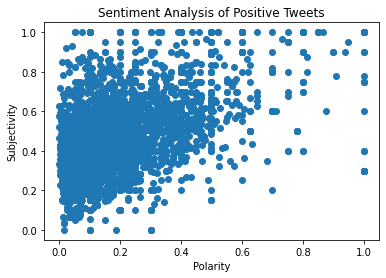

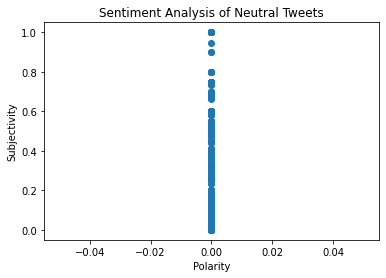

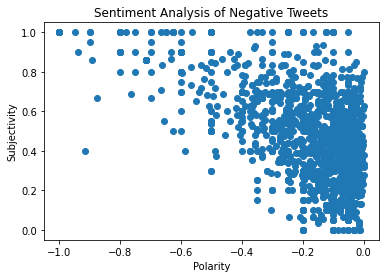

In [30]:
# Positive Tweets
plt.scatter(positive_tweets["Polarity"], positive_tweets["Subjectivity"])

plt.title('Sentiment Analysis of Positive Tweets') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

# Neutral Tweets
plt.scatter(neutral_tweets["Polarity"], neutral_tweets["Subjectivity"])

plt.title('Sentiment Analysis of Neutral Tweets') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

# Negative Tweets
plt.scatter(negative_tweets["Polarity"], negative_tweets["Subjectivity"])

plt.title('Sentiment Analysis of Negative Tweets') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity')
plt.show()

In [31]:
print(data["Analysis"].value_counts())
print("Total:", data.shape[0])
print()

print("Percentage of positive Tweets:", (positive_tweets.shape[0] / data.shape[0]))
print()

print("Percentage of neutral Tweets:", (neutral_tweets.shape[0] / data.shape[0]))
print()

print("Percentage of negative Tweets:", (negative_tweets.shape[0] / data.shape[0]))

Positive    3417
Neutral     2265
Negative    1818
Name: Analysis, dtype: int64
Total: 7500

Percentage of positive Tweets: 0.4556

Percentage of neutral Tweets: 0.302

Percentage of negative Tweets: 0.2424


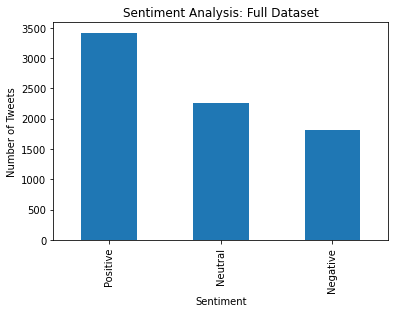

In [32]:
plt.title("Sentiment Analysis: Full Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
data["Analysis"].value_counts().plot(kind = "bar")
plt.show()

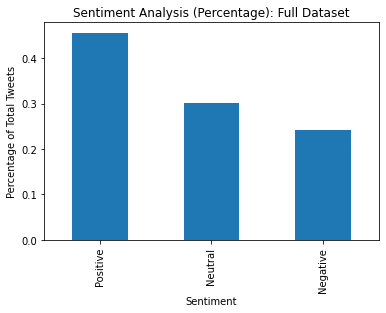

In [33]:
plt.title("Sentiment Analysis (Percentage): Full Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Percentage of Total Tweets")
((data["Analysis"].value_counts())/data.shape[0]).plot(kind = "bar")
plt.show()

### Analysis: Monthly

In [34]:
months = list(dict.fromkeys(data["Month"].values))
sentiments = list(dict.fromkeys(data["Analysis"].values))
sentiment_colors = {"Positive": "Blue", "Negative": "Red", "Neutral": "Gray"}

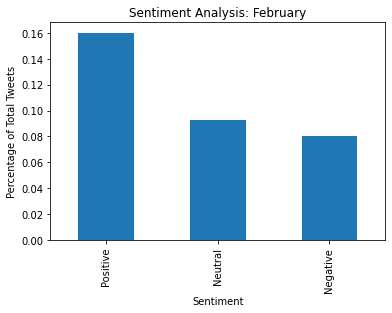

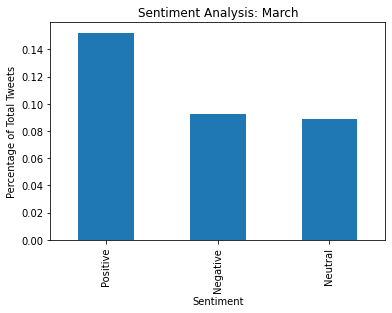

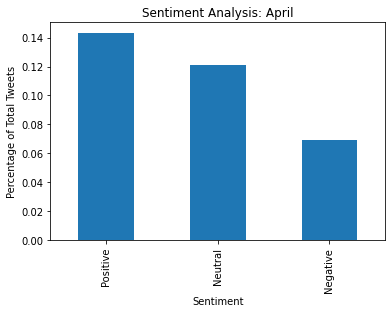

In [39]:
for month in months:
    month_tweets = data.loc[data["Month"] == month]
    plt.title("Sentiment Analysis: " + month)
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage of Total Tweets")
    ((month_tweets["Analysis"].value_counts())/data.shape[0]).plot(kind = 'bar')
    plt.show()

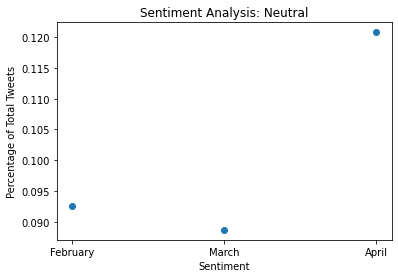

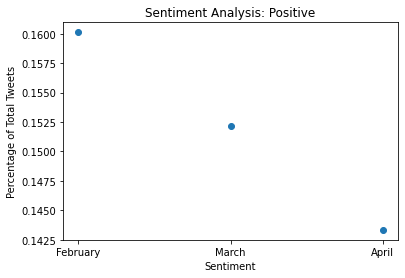

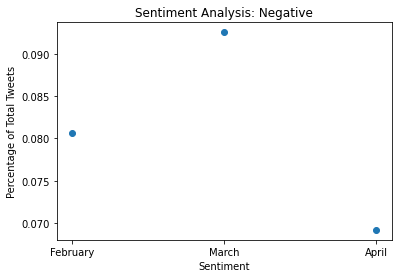

In [40]:
for sentiment in sentiments:
    month_percentages = []
    sentiment_tweets = data.loc[data["Analysis"] == sentiment]
    plt.title("Sentiment Analysis: " + sentiment)
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage of Total Tweets")
    for month in months:
        month_tweets = sentiment_tweets.loc[sentiment_tweets["Month"] == month]
        month_percentages.append(month_tweets["Analysis"].value_counts()/data.shape[0])
    plt.scatter(months, month_percentages) 
    plt.show()

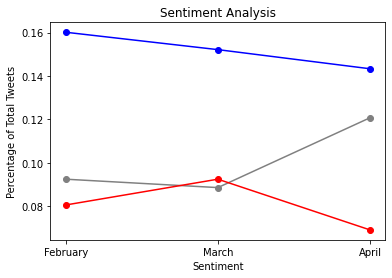

In [41]:
plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Percentage of Total Tweets")
    
for sentiment in sentiments:
    month_percentages = []
    sentiment_tweets = data.loc[data["Analysis"] == sentiment]
    for month in months:
        month_tweets = sentiment_tweets.loc[sentiment_tweets["Month"] == month]
        month_percentages.append(month_tweets["Analysis"].value_counts()/data.shape[0])
    plt.scatter(months, month_percentages, c = sentiment_colors[sentiment]) 
    plt.plot(months, month_percentages, c = sentiment_colors[sentiment])
plt.show()

## Naive Bayes Classification

### Training the model

In [43]:
corpus = pd.read_csv("full_corpus.csv")

corpus["TweetText"] = corpus["TweetText"].apply(cleanText)
corpus["List of Words"] = corpus["TweetText"].apply(convertToList)

In [44]:
corpus.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText,List of Words
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,now all has to do is get swype on the iphone ...,"[get, swype, iphone, crack, iphone]"
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,will be adding more carrier support to the ip...,"[adding, carrier, support, iphone, 4s, announced]"
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,hilarious video - guy does a duet with 's si...,"[hilarious, video, guy, duet, 's, siri, pretty..."
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,you made it too easy for me to switch to iph...,"[made, easy, switch, iphone, see, ya]"
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,i just realized that the reason i got into twi...,"[realized, reason, got, twitter, ios5, thanks]"


In [45]:
training_data, testing_data = train_test_split(corpus, test_size = 0.05)

print(corpus.shape)
print(training_data.shape)
print(testing_data.shape)

(5113, 6)
(4857, 6)
(256, 6)


In [46]:
training_data_list = []
for index, row in training_data.iterrows():
    training_data_list.append((row["TweetText"], row["Sentiment"]))

testing_data_list = []
for index, row in testing_data.iterrows():
    testing_data_list.append((row["TweetText"], row["Sentiment"]))

In [48]:
# This function was adapted from https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
# (The resource above is open source).
def build(input_data):
    world_list = []
    
    for (words, sentiment) in input_data:
        world_list.extend(words)

    words = nltk.FreqDist(world_list)
    word_features = words.keys()
    
    return word_features

In [49]:
# This function was adapted from https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
# (The resource above is open source).
def get_features(text):
    words = set(text)
    features = {}
    
    for word in word_features:
        features['contains(%s)' % word] = (word in words)
        
    return features 

In [50]:
word_features = build(training_data_list)
training_features = nltk.classify.apply_features(get_features, training_data_list)

In [51]:
naive_bayes_classifier = nltk.NaiveBayesClassifier.train(training_features)

In [52]:
# This piece of code was suggested in https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
classifier_result_labels = [naive_bayes_classifier.classify(get_features(tweet[0])) for tweet in testing_data_list]


In [53]:
print("Percentage of Positive Sentiments:", classifier_result_labels.count('positive') / testing_data.shape[0])
print()
print("Percentage of Negative Sentiments:", classifier_result_labels.count('negative') / testing_data.shape[0])


Percentage of Positive Sentiments: 0.0078125

Percentage of Negative Sentiments: 0.0703125


### Applying the Model to Covid-19 Twitter Data

In [54]:
# training_data, testing_data = train_test_split(data, test_size = 0.2)

In [55]:
print(data.shape)
print(training_data.shape)
print(testing_data.shape)

(7500, 7)
(4857, 6)
(256, 6)


In [ ]:
# word_features = build(training_data_list)
# training_features = nltk.classify.apply_features(get_features, training_data_list)

In [ ]:
# naive_bayes_classifier = nltk.NaiveBayesClassifier.train(training_features)

In [56]:
# This piece of code was suggested in https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
covid_classifier_labels = [naive_bayes_classifier.classify(get_features(row[3])) for index, row in data.iterrows()]

In [57]:
data["Classification"] = covid_classifier_labels
data["Ensemble"] = covid_classifier_labels # temporary

In [58]:
for index, row in data.iterrows():
    if row["Polarity"] < -0.2:
        row["Ensemble"] = "negative"
    elif row["Polarity"] > 0.2 and row["Classification"] == "neutral":
        row["Ensemble"] = "positive"

In [59]:
data.loc[data["Polarity"] < -0.2, "Ensemble"] = "negative"
data.loc[data["Polarity"] > 0.2, "Ensemble"] = "positive"

In [60]:
print(data["Ensemble"].value_counts())

irrelevant    4078
positive      1659
neutral       1141
negative       622
Name: Ensemble, dtype: int64


## Covid Cases

In [61]:
confirmed = pd.read_csv('covid_confirmed.csv')
recovered = pd.read_csv('covid_recovered.csv')
deaths = pd.read_csv('covid_deaths.csv')

In [62]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45


In [68]:
confirmed_in = confirmed.loc[confirmed["Country/Region"] == "India"]
deaths_in = deaths.loc[deaths["Country/Region"] == "India"]
recovered_in = recovered.loc[recovered["Country/Region"] == "India"]

In [69]:
confirmed_in.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20
131,NaN,India,21.0,78.0,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,1998,2543,2567,3082,3588,4778,5311,5916,6725,7598,8446,9205,10453,11487,12322,13430,14352,15722,17615,18539,20080,21370,23077,24530,26283,27890,29451,31324,33062,34863,37257,39699,42505,46437,49400,52987,56351,59695,62808,67161


In [70]:
df_list = [confirmed_in, deaths_in, recovered_in]

for i in range(3):
    df = df_list[i].drop(columns = ["Province/State", "Country/Region", "Lat", "Long"])
    dates, values = [], []

    for j in df:
        dates.append(j)
        values.append(df.iloc[0][j])
        
    new_data = {'Date': dates, 'Cases': values}
    df_list[i] = pd.DataFrame(new_data)

confirmed_in = df_list[0]
deaths_in = df_list[1]
recovered_in = df_list[2]

In [74]:
confirmed_in.head()

,Date,Cases
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0


In [75]:
confirmed_in.tail()

,Date,Cases
105,5/6/20,52987
106,5/7/20,56351
107,5/8/20,59695
108,5/9/20,62808
109,5/10/20,67161


In [76]:
deaths_in.head()

,Date,Cases
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0


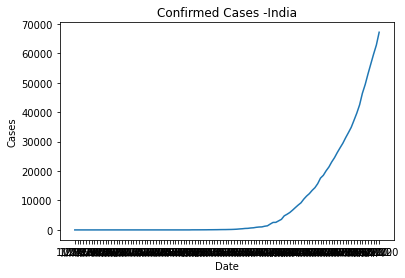

In [77]:
plt.title("Confirmed Cases -India")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.plot(confirmed_in["Date"], confirmed_in["Cases"])
plt.show()

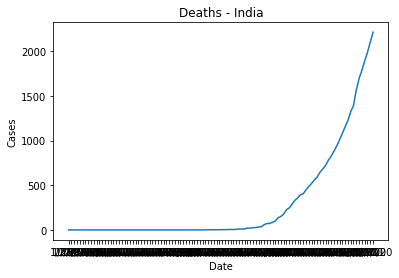

In [78]:
plt.title("Deaths - India")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.plot(deaths_in["Date"], deaths_in["Cases"])
plt.show()

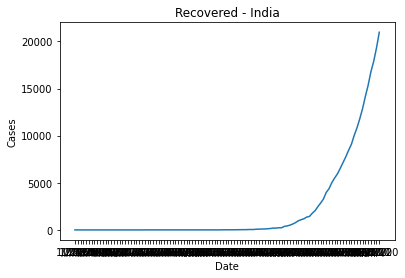

In [79]:
plt.title("Recovered - India")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.plot(recovered_in["Date"], recovered_in["Cases"])
plt.show()

In [80]:
def convertToWeekly(df):
    new_dates, new_cases = [], []
    count = 0

    for index, row in df.iterrows():
        if (count == 6):
            new_dates.append(row["Date"])
            new_cases.append(row["Cases"])
            count = 0
        else:
            count += 1
    
    new_data = {'Date': new_dates, 'Cases': new_cases}
    return pd.DataFrame(new_data)

In [82]:
confirmed_in_weekly = convertToWeekly(confirmed_in)
deaths_in_weekly = convertToWeekly(deaths_in)
recovered_in_weekly = convertToWeekly(recovered_in)

In [83]:
confirmed_in_weekly.head()

,Date,Cases
0,1/28/20,0
1,2/4/20,3
2,2/11/20,3
3,2/18/20,3
4,2/25/20,3


In [84]:
confirmed_in_weekly.tail()

,Date,Cases
10,4/7/20,5311
11,4/14/20,11487
12,4/21/20,20080
13,4/28/20,31324
14,5/5/20,49400


In [85]:
dates = list(confirmed_in_weekly["Date"].values)

In [86]:
# I realize that this is an incredibly inefficient function
def getWeeklyResults(df):
    results_list = []

    for date in dates:
        month = date[0:1]
        day = ""
        
        if len(date) == 7:
            day = date[2:4]
        else:
            day = date[2:3]
                
        date_results = []
    
        for index, row in df.iterrows():
            tweet_date = row["Date"]
            tweet_month = date[0:1]
            tweet_day = "" 
            
            if len(tweet_date) == 7:
                tweet_day = tweet_date[2:4]
            else:
                tweet_day = tweet_date[2:3]
            
            if tweet_month <= month:
                if tweet_day <= day:
                    date_results.append(row["Ensemble"])
        
        results_list.append(date_results)
    
    return results_list

In [87]:
weekly_results = getWeeklyResults(data)

In [88]:
print(len(weekly_results[7]))

2658


In [89]:
week_counts = {}
for i in range(len(weekly_results)):
    if (len(weekly_results[i]) != 0):
        date = dates[i]
        total_count = len(weekly_results[i])
        counter = Counter(weekly_results[i])
        positive_percent = counter["positive"] / total_count
        neutral_percent = counter["neutral"] / total_count
        negative_percent = counter["negative"] / total_count
        irrelevant_percent = counter["irrelevant"] / total_count
        week_counts[date] = [total_count, positive_percent, neutral_percent, negative_percent]

In [90]:
week_counts

{'1/28/20': [5000, 0.219, 0.159, 0.084],
 '2/18/20': [3866,
  0.21857216761510606,
  0.16839110191412313,
  0.08872219348163476],
 '2/25/20': [5000, 0.219, 0.159, 0.084],
 '2/4/20': [5551,
  0.2179787425689065,
  0.15582777877859846,
  0.08557016753738066],
 '3/17/20': [2658,
  0.22234762979683972,
  0.17381489841986456,
  0.09857035364936043],
 '3/24/20': [5000, 0.219, 0.159, 0.084],
 '3/3/20': [5000, 0.219, 0.159, 0.084],
 '3/31/20': [5000, 0.219, 0.159, 0.084],
 '4/14/20': [2500, 0.2268, 0.1756, 0.0992],
 '4/21/20': [5000, 0.219, 0.159, 0.084],
 '4/28/20': [5000, 0.219, 0.159, 0.084],
 '4/7/20': [7500, 0.2212, 0.15213333333333334, 0.08293333333333333],
 '5/5/20': [7500, 0.2212, 0.15213333333333334, 0.08293333333333333]}

In [91]:
def normalize(df):
    df["Normalized"] = (df["Cases"] - df["Cases"].min()) / (df["Cases"].max() - df["Cases"].min())
    return df

In [92]:
for df in [confirmed_in_weekly, recovered_in_weekly, deaths_in_weekly]:
    df = normalize(df)

In [93]:
recovered_in.tail()

,Date,Cases
105,5/6/20,15331
106,5/7/20,16776
107,5/8/20,17887
108,5/9/20,19301
109,5/10/20,20969


In [94]:
def clean(df):
    for index, row in df.iterrows():
        if row["Date"] not in week_counts:
            df = df[df.Date != row["Date"]]
    return df

In [95]:
confirmed_in_weekly = clean(confirmed_in_weekly)
recovered_in_weekly = clean(recovered_in_weekly)
deaths_in_weekly = clean(deaths_in_weekly)

In [96]:
def addTweetSentiment(df, i):
    sentiment_list = []
    
    for index, row in df.iterrows():
        if row["Date"] in week_counts:
            sentiments = week_counts[row["Date"]]
            sentiment_list.append(sentiments[i])
        
    df[str(i)] = sentiment_list
    return df

In [97]:
for i in range(1, 4, 1):
    confirmed_in_weekly = addTweetSentiment(confirmed_in_weekly, i)
    recovered_in_weekly = addTweetSentiment(recovered_in_weekly, i)
    deaths_in_weekly = addTweetSentiment(deaths_in_weekly, i)

In [98]:
confirmed_in_weekly.head()

,Date,Cases,Normalized,1,2,3
0,1/28/20,0,0.000000,0.219000,0.159000,0.084000
1,2/4/20,3,0.000061,0.217979,0.155828,0.085570
3,2/18/20,3,0.000061,0.218572,0.168391,0.088722
4,2/25/20,3,0.000061,0.219000,0.159000,0.084000
5,3/3/20,5,0.000101,0.219000,0.159000,0.084000


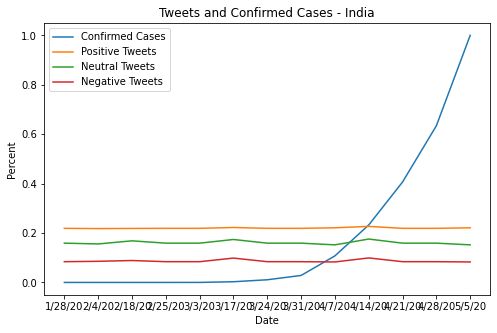

In [106]:
plt.rcParams["figure.figsize"] = (8,5)

plt.title("Tweets and Confirmed Cases - India")
plt.xlabel("Date")
plt.ylabel("Percent")

plt.plot(confirmed_in_weekly["Date"], confirmed_in_weekly["Normalized"])
for i in range(1, 4, 1):
    plt.plot(confirmed_in_weekly["Date"], confirmed_in_weekly[str(i)])
plt.legend(["Confirmed Cases", "Positive Tweets", "Neutral Tweets", "Negative Tweets"])

plt.show()

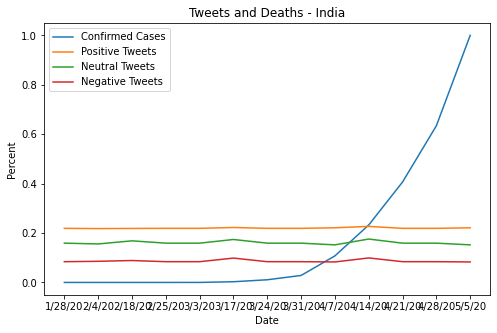

In [108]:
plt.rcParams["figure.figsize"] = (8,5)

plt.title("Tweets and Deaths - India")
plt.xlabel("Date")
plt.ylabel("Percent")

plt.plot(confirmed_in_weekly["Date"], confirmed_in_weekly["Normalized"])
for i in range(1, 4, 1):
    plt.plot(confirmed_in_weekly["Date"], confirmed_in_weekly[str(i)])
plt.legend(["Confirmed Cases", "Positive Tweets", "Neutral Tweets", "Negative Tweets"])

plt.show()

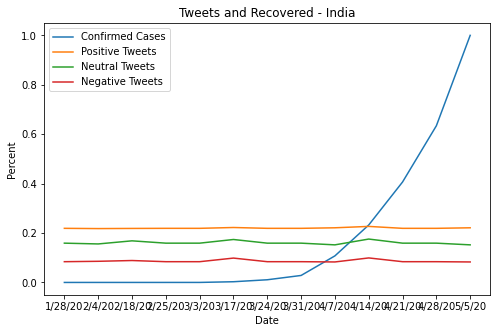

In [109]:
plt.rcParams["figure.figsize"] = (8,5)

plt.title("Tweets and Recovered - India")
plt.xlabel("Date")
plt.ylabel("Percent")

plt.plot(confirmed_in_weekly["Date"], confirmed_in_weekly["Normalized"])
for i in range(1, 4, 1):
    plt.plot(confirmed_in_weekly["Date"], confirmed_in_weekly[str(i)])
plt.legend(["Confirmed Cases", "Positive Tweets", "Neutral Tweets", "Negative Tweets"])

plt.show()

In [110]:
confirmed_in_weekly = confirmed_in_weekly.rename(columns = {"1": "Positive Sentiment", "2": "Neutral Sentiment", "3": "Negative Sentiment"})
recovered_in_weekly = recovered_in_weekly.rename(columns = {"1": "Positive Sentiment", "2": "Neutral Sentiment", "3": "Negative Sentiment"})
deaths_in_weekly = deaths_in_weekly.rename(columns = {"1": "Positive Sentiment", "2": "Neutral Sentiment", "3": "Negative Sentiment"})

In [114]:
confirmed_in_weekly.corr()

,Cases,Normalized,Positive Sentiment,Neutral Sentiment,Negative Sentiment
Cases,1.000000,1.000000,0.182485,-0.295673,-0.184889
Normalized,1.000000,1.000000,0.182485,-0.295673,-0.184889
Positive Sentiment,0.182485,0.182485,1.000000,0.585380,0.760407
Neutral Sentiment,-0.295673,-0.295673,0.585380,1.000000,0.927522
Negative Sentiment,-0.184889,-0.184889,0.760407,0.927522,1.000000


In [115]:
recovered_in_weekly.corr()

,Cases,Normalized,Positive Sentiment,Neutral Sentiment,Negative Sentiment
Cases,1.000000,1.000000,0.102878,-0.342477,-0.233100
Normalized,1.000000,1.000000,0.102878,-0.342477,-0.233100
Positive Sentiment,0.102878,0.102878,1.000000,0.585380,0.760407
Neutral Sentiment,-0.342477,-0.342477,0.585380,1.000000,0.927522
Negative Sentiment,-0.233100,-0.233100,0.760407,0.927522,1.000000


In [117]:
deaths_in_weekly.corr()

,Cases,Normalized,Positive Sentiment,Neutral Sentiment,Negative Sentiment
Cases,1.000000,1.000000,0.191877,-0.289816,-0.175757
Normalized,1.000000,1.000000,0.191877,-0.289816,-0.175757
Positive Sentiment,0.191877,0.191877,1.000000,0.585380,0.760407
Neutral Sentiment,-0.289816,-0.289816,0.585380,1.000000,0.927522
Negative Sentiment,-0.175757,-0.175757,0.760407,0.927522,1.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


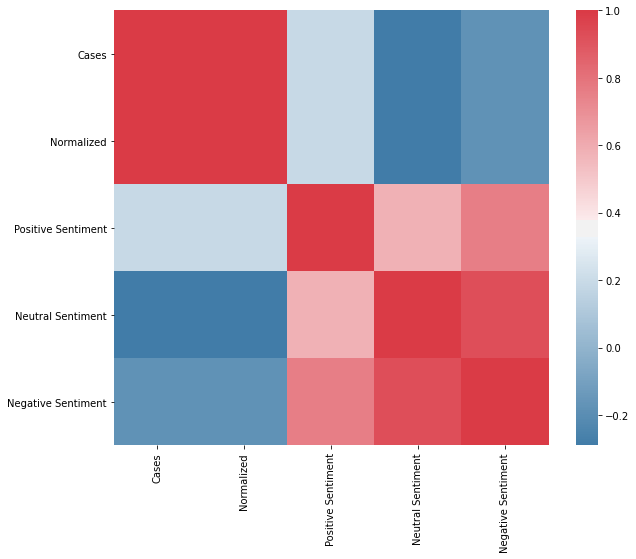

In [119]:
import seaborn as sns
f, ax=plt.subplots(figsize=(10,8))
corr=deaths_in_weekly.corr()
sns.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sns.diverging_palette(240,10,as_cmap=True),square=True,ax=ax)

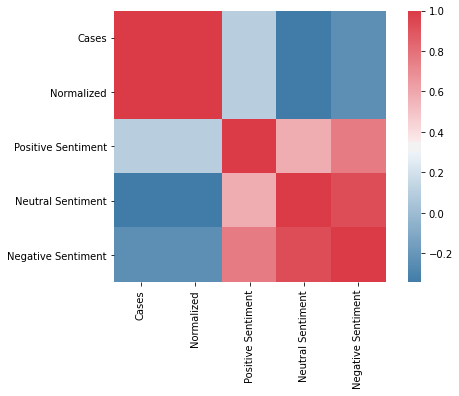

In [121]:
import seaborn as sns
f, ax=plt.subplots(figsize=(8,5))
corr=recovered_in_weekly.corr()
sns.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sns.diverging_palette(240,10,as_cmap=True),square=True,ax=ax)